In [1]:
import ee
from drought.data import ee_climate, pipeline
from drought.visualization import plot
import geemap
import matplotlib.pyplot as plt
import pandas as pd
import importlib

## Prerequisites

Before running the notebook, make sure to authenticate with Google Earth 
Engine. 

You can do so by running ```earthengine authenticate``` on the command line
or uncommenting the authentication cell below. See [here](https://developers.google.com/earth-engine/guides/python_install#authentication) for more details.

### Earth Engine Initialization

In [ ]:
# Uncomment if you want to authenticate within jupyter notebook.
#ee.Authenticate()

In [2]:
ee.Initialize()

## Get Climate Data

In [3]:
# Dates of interest.
start_date = ee.Date('2019-01-01')
end_date = ee.Date('2023-01-01')

# Get regions of interest.
ee_geoms = pipeline.get_ee_polygons()

# Specify resolution.
scale = 5000

# Fetch climate data from Earth Engine as Pandas DataFrame.
climate_monthly_pdf = ee_climate.get_monthly_climate_data_as_pdf(
        start_date, end_date, ee_geoms, scale)

### Plot total monthly averages

In [14]:
# Calculate monthly mean for all three years in aggregate.
total_monthly_mean = climate_monthly_pdf.groupby(['month', 'polygon_id']) \
                                .mean(numeric_only=True).reset_index() \
                                .drop(columns=['year'])

In [15]:
# Palette for plotting. Colors can be accessed by indexing - plot.palette[i]
plot.palette

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.7612000000000001, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.5012000000000001),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.43879999999999986, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.6987999999999996)]

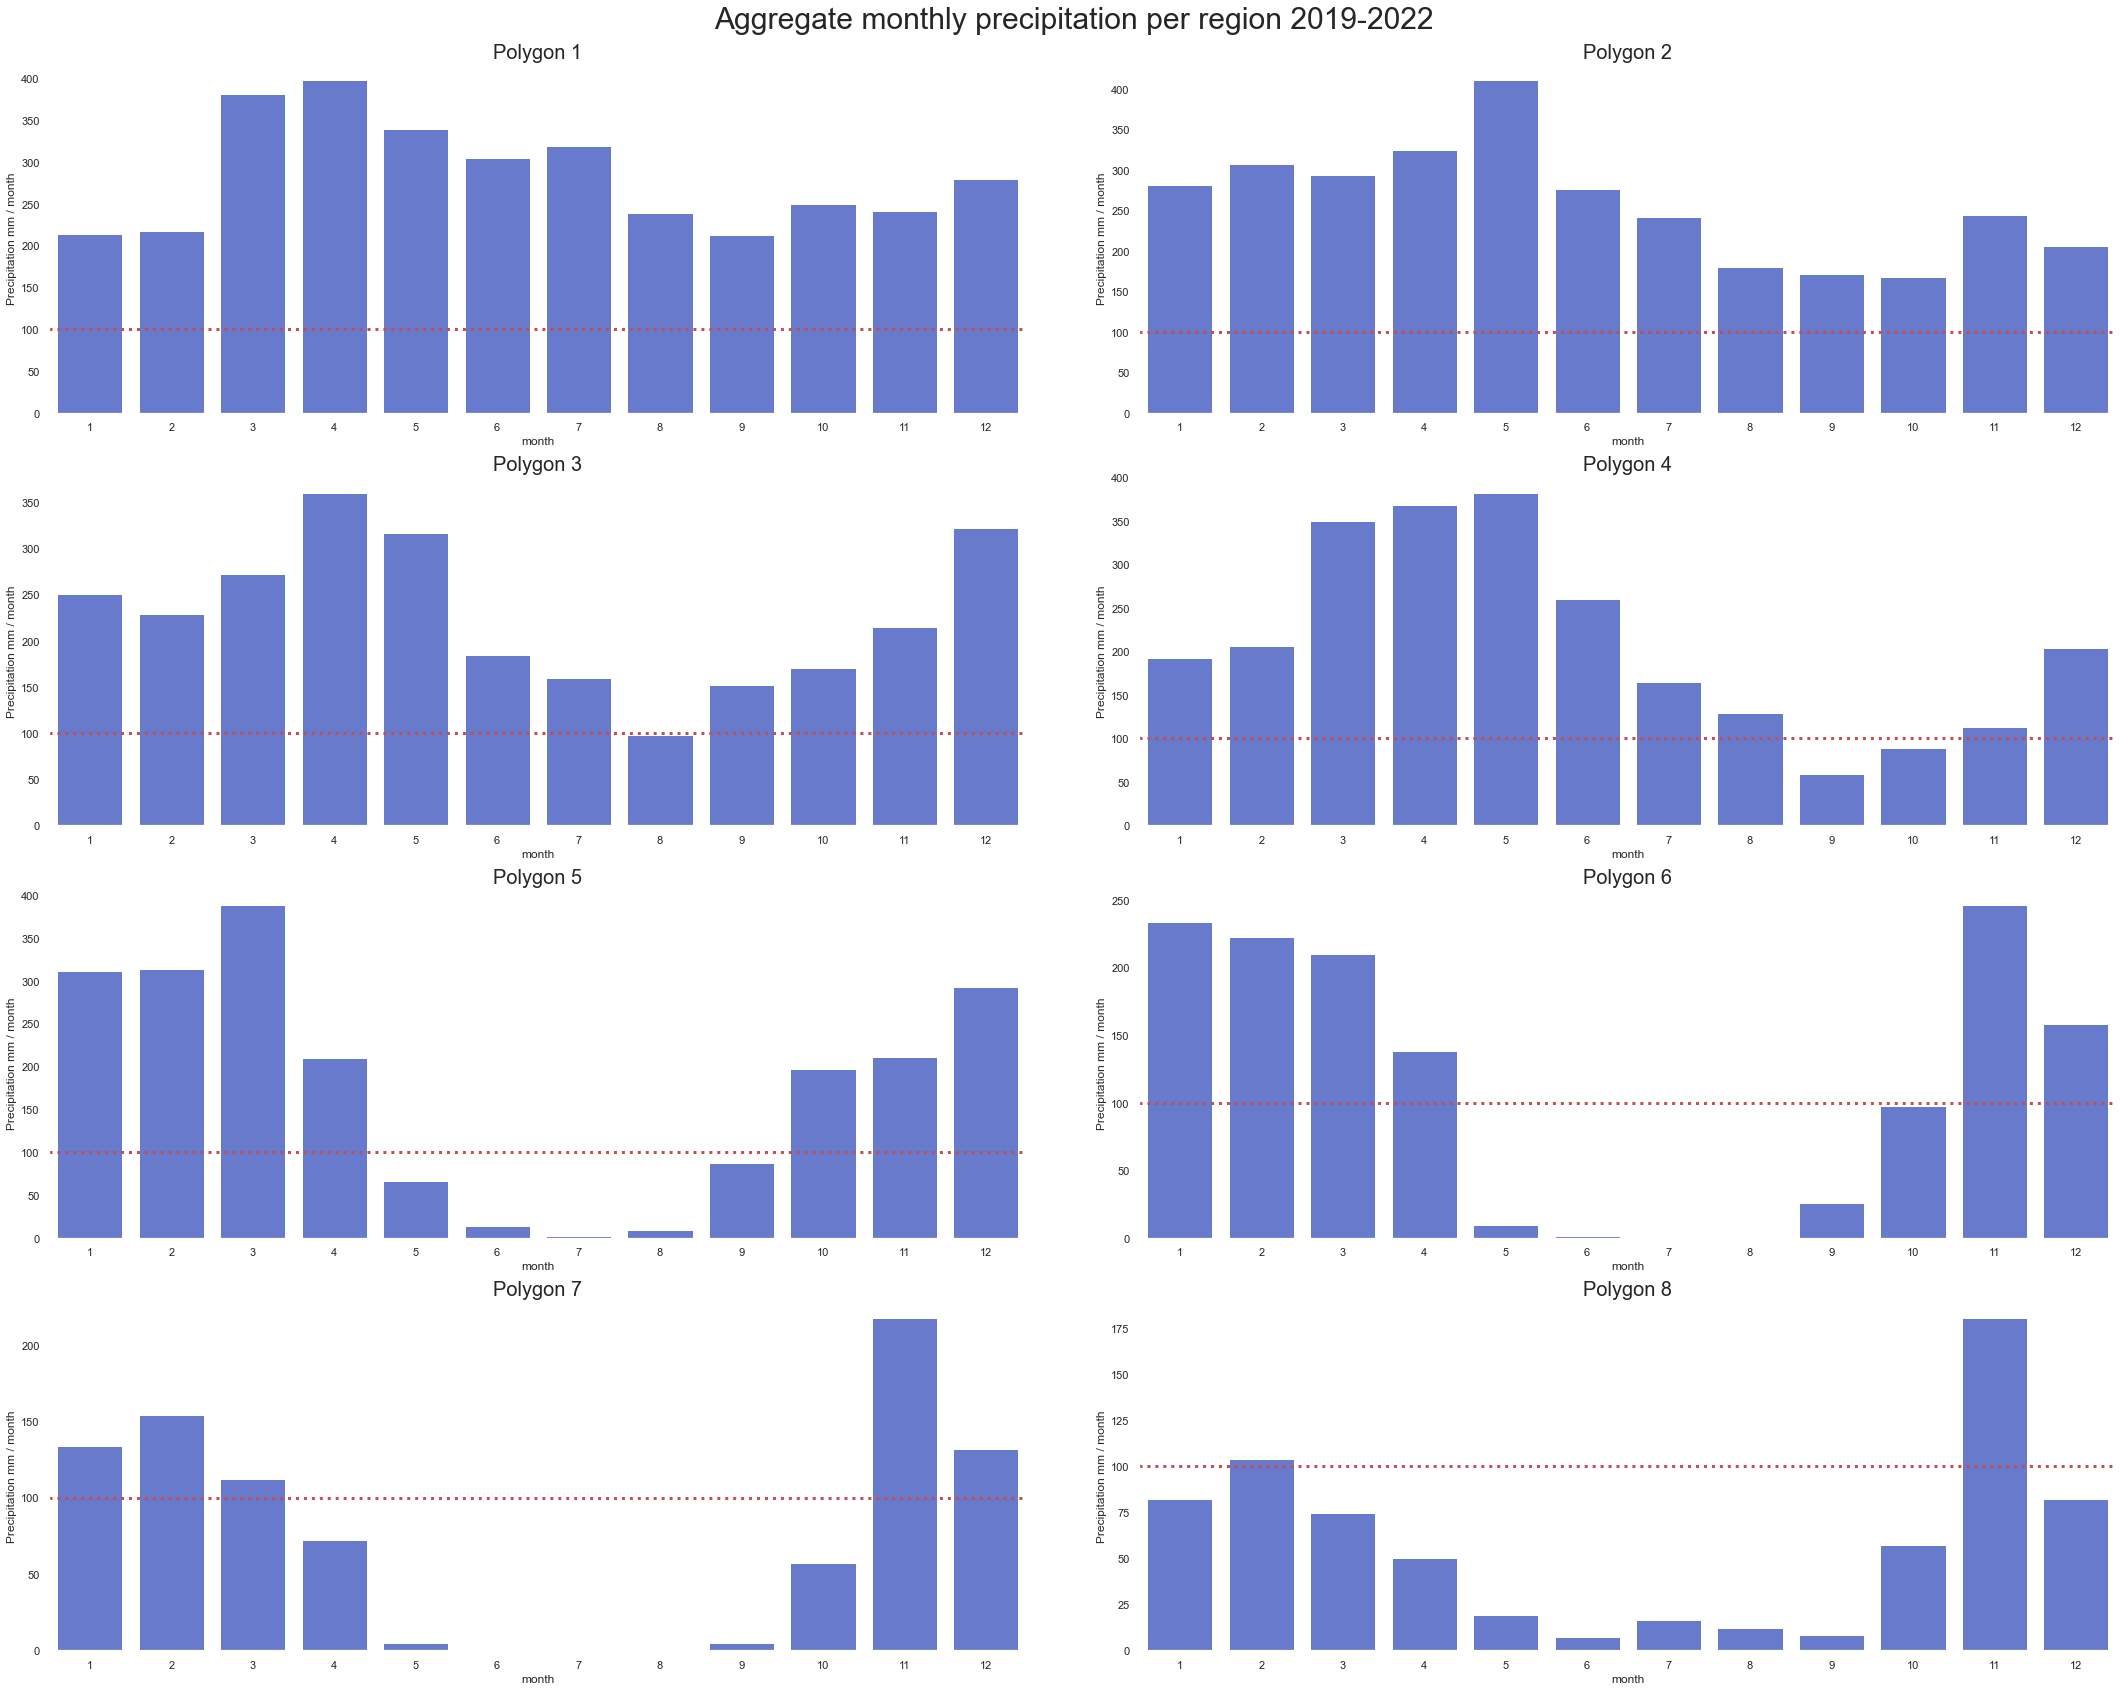

In [16]:
# Plot aggregate monthly precipitation per region.
fig = plot.barplot_per_polygon(total_monthly_mean,
                              x='month', 
                              y='precipitation', 
                              ylabel="Precipitation mm / month",
                              title="Aggregate monthly precipitation per region 2019-2022",
                              color=plot.palette[5])
# Mark the 100mm precipitation line that signifies a dry month.
[subplot.axhline(y=100, color = 'r', linestyle = 'dotted', linewidth=3) 
 for subplot in fig.get_axes()]
plt.show()

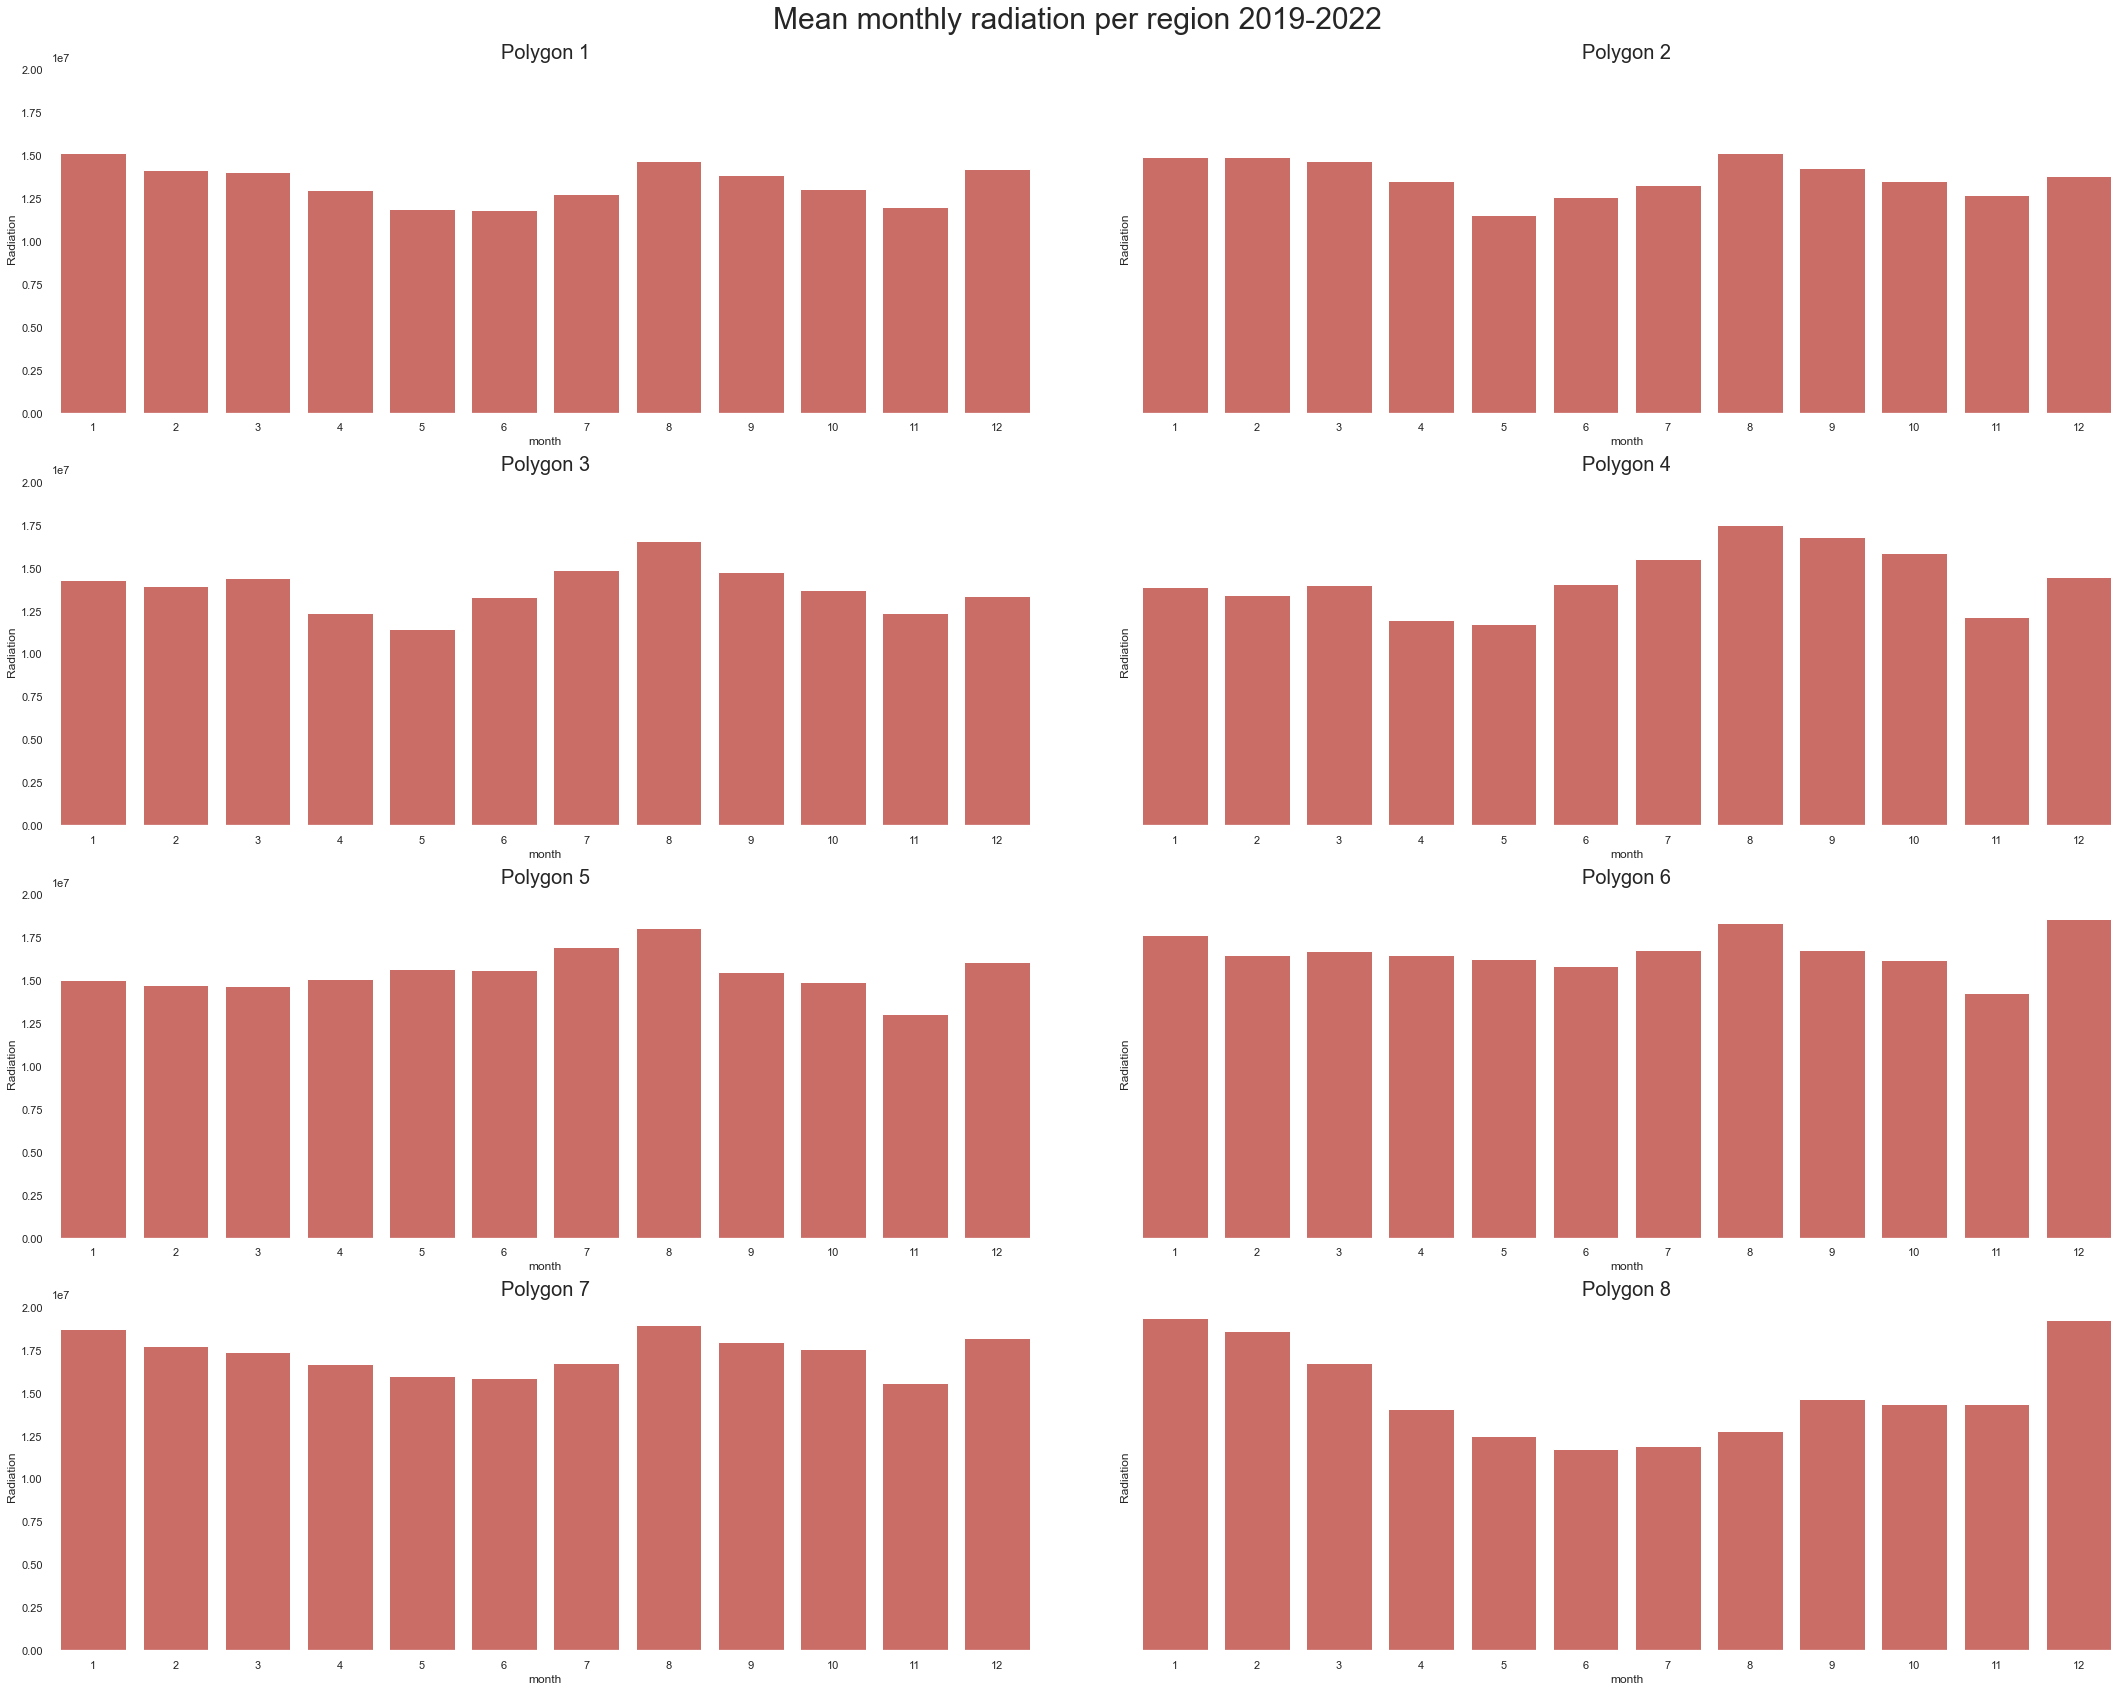

In [17]:
# Plot aggregate monthly radiation per region.
fig = plot.barplot_per_polygon(total_monthly_mean,
                              x='month', 
                              y='radiation', 
                              ylabel="Radiation",
                              title="Mean monthly radiation per region 2019-2022",
                              color=plot.palette[0],
                              sharey=True)
plt.show()

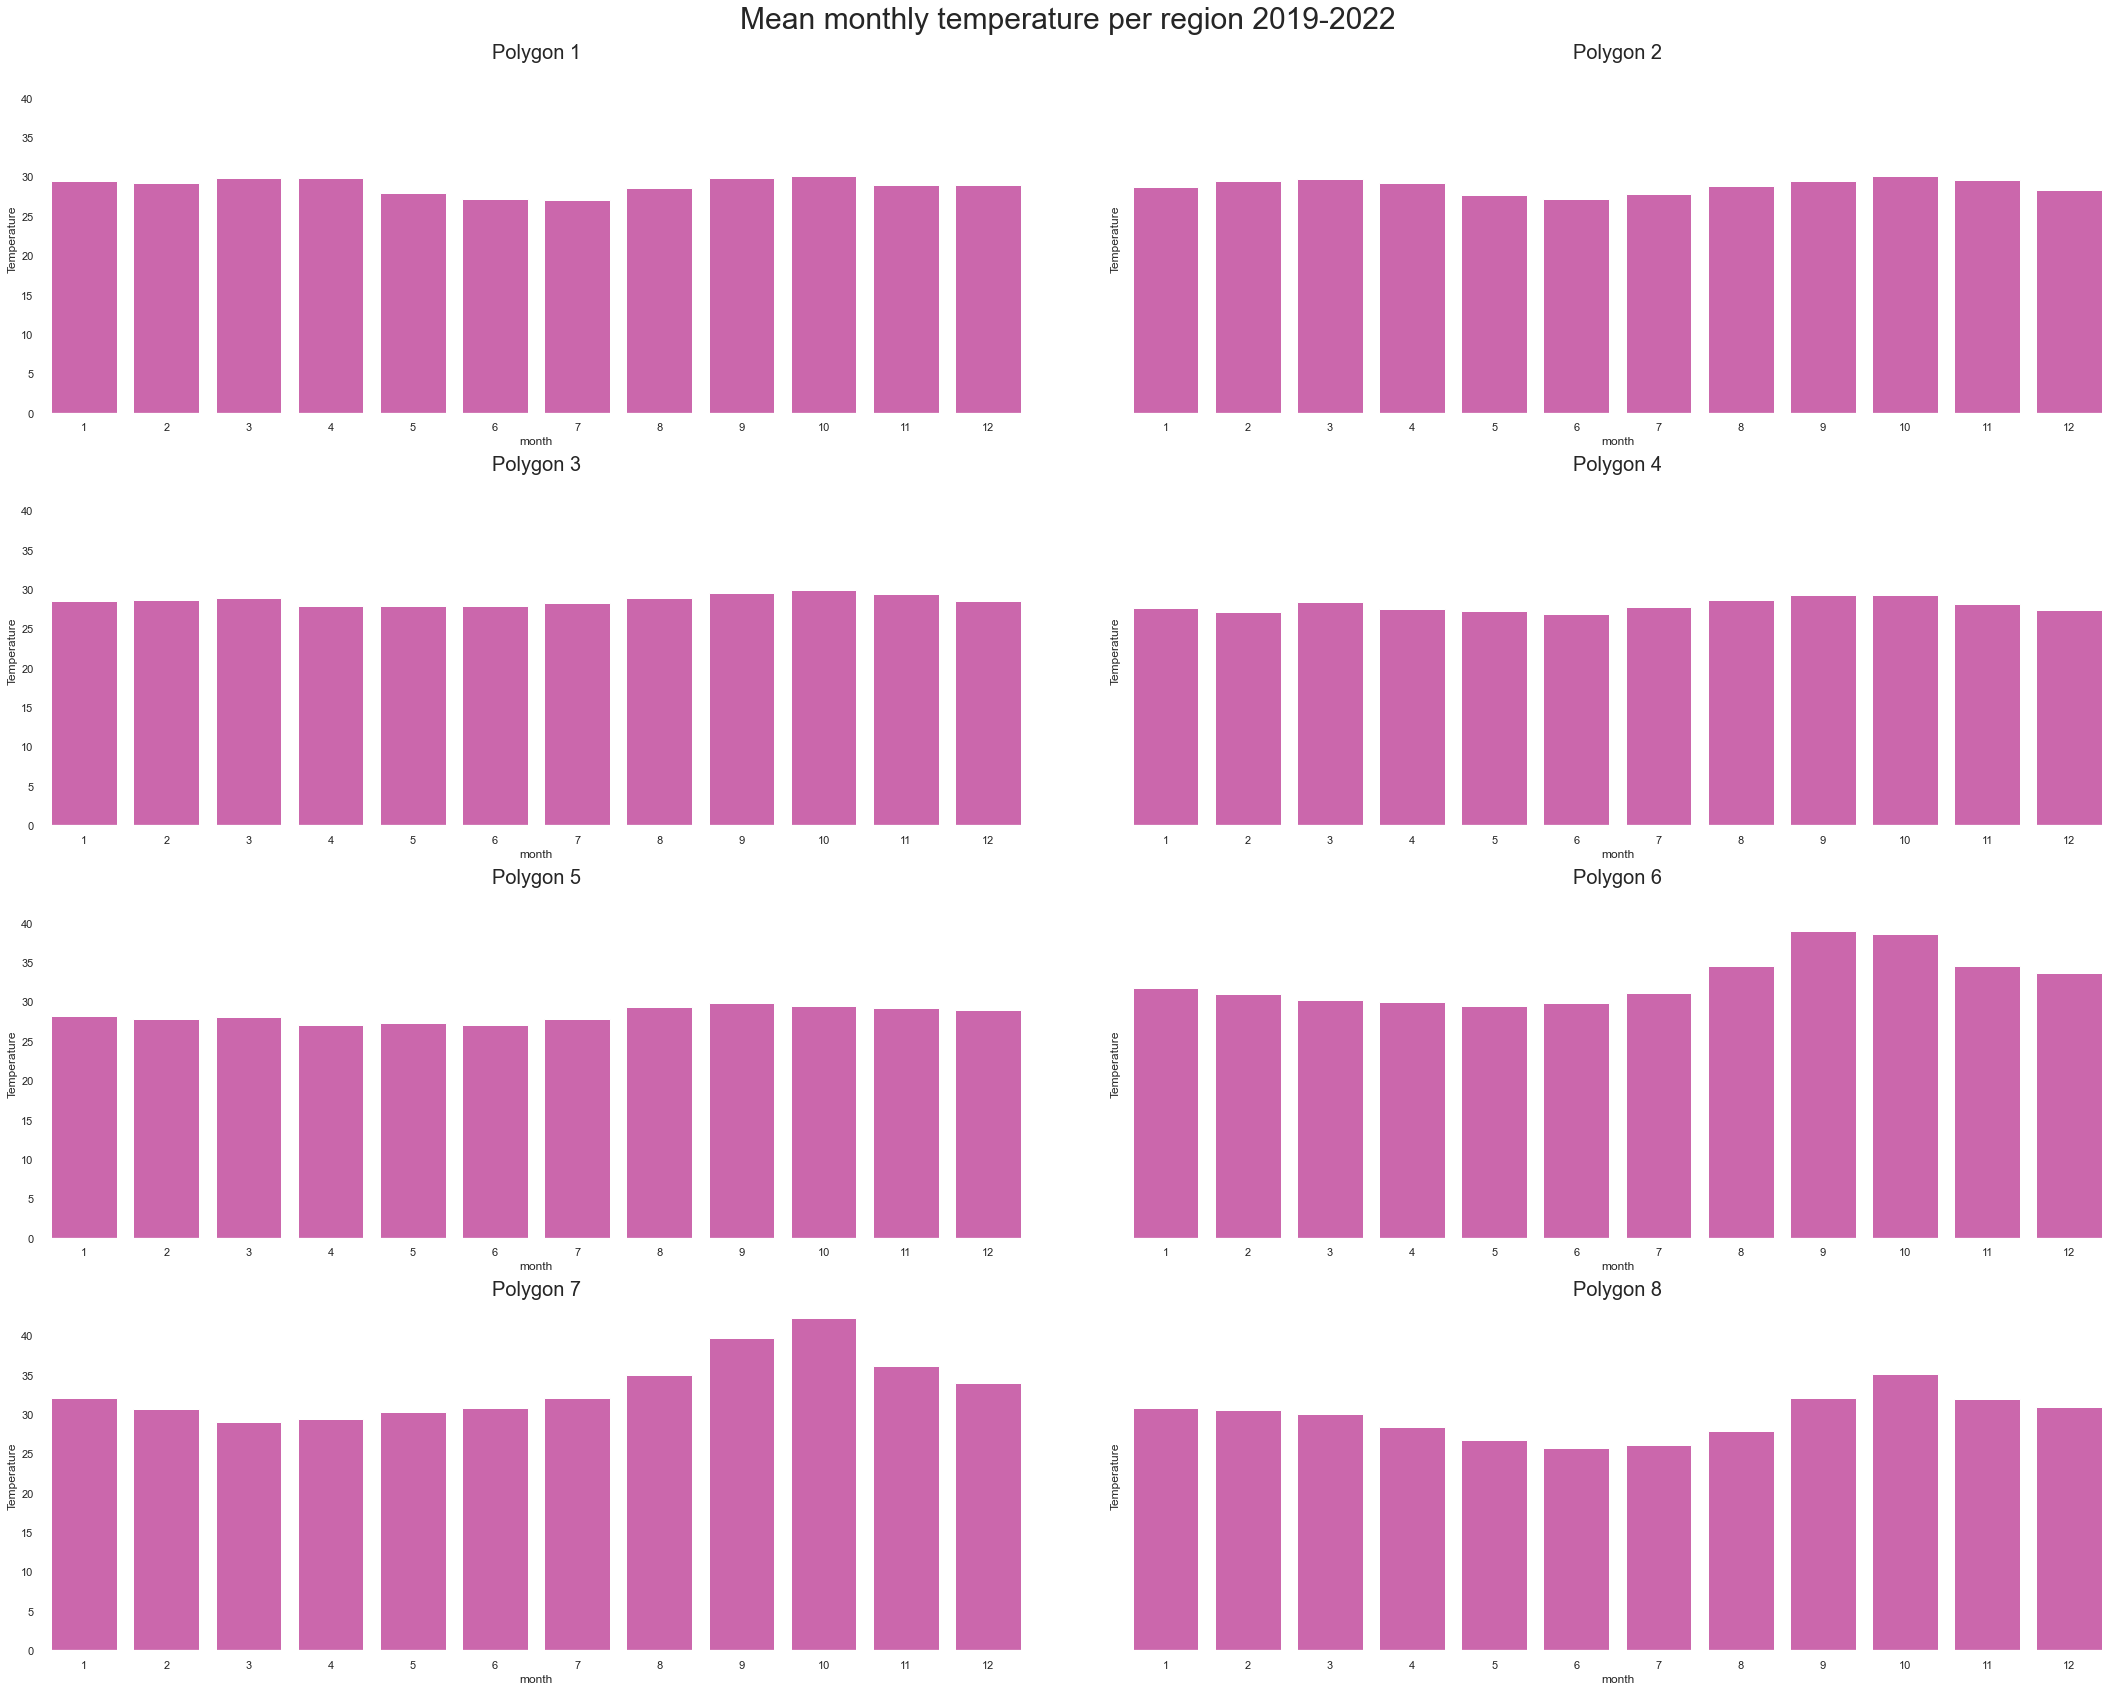

In [18]:
# Plot aggregate monthly temperature per region.
fig = plot.barplot_per_polygon(total_monthly_mean,
                              x='month', 
                              y='temperature', 
                              ylabel="Temperature",
                              title="Mean monthly temperature per region 2019-2022",
                              color=plot.palette[7],
                              sharey=True)
plt.show()